# atmodeller

## Science Cases

Following the Monte Carlo approach in 3_monte_carlo.ipynb, we sample the possible atmospheres of known exoplanets that can arise for different planetary conditions.


In [26]:
#from atmodeller import debug_logger
from typing import Type
from atmodeller.interior_atmosphere import InteriorAtmosphereSystem, Planet, Species
from atmodeller.constraints import MassConstraint, IronWustiteBufferConstraintHirschmann, SystemConstraints, FugacityConstraint, PressureConstraint
from atmodeller.eos.holland import (
    CO2_CORK_simple_HP91,
    CO2_MRK_simple_HP91,
    get_holland_eos_models,
)
from atmodeller.eos.saxena import (
    get_saxena_eos_models
)
from atmodeller.interfaces import (
    GasSpecies,
    IdealGas,
    NoSolubility,
    RealGasABC,
    ThermodynamicDataset,
)
from atmodeller.solubilities import PeridotiteH2O, BasaltDixonCO2, BasaltLibourelN2, BasaltDixonH2O, BasaltS2, BasaltH2, BasaltCO, BasaltLibourelN2, BasaltCH4, BasaltHe, BasaltCl2
from atmodeller.utilities import earth_oceans_to_kg
import numpy as np
import csv
from atmodeller import debug_logger
import logging

thermodynamic_data: Type[ThermodynamicDataset] = ThermodynamicDataset

eos_models_HP: dict[str, RealGasABC] = get_holland_eos_models()
eos_models_SS: dict[str, RealGasABC] = get_saxena_eos_models()

logger = debug_logger()
logger.setLevel(logging.INFO)


In [2]:
#Plotting Tools:
import matplotlib
import matplotlib.pyplot as plt
plt.rc("savefig", dpi=300)
plt.rc('figure', dpi=300)
plt.rc('text', usetex=True)
plt.rc('font', size=15)
plt.rc('xtick', direction='in') 
plt.rc('ytick', direction='in')
plt.rc('xtick.major', pad=5) 
plt.rc('xtick.minor', pad=5)
plt.rc('ytick.major', pad=5) 
plt.rc('ytick.minor', pad=5)
plt.rc('lines', dotted_pattern = [0.5, 1.1])

font={'weight':'bold',
     'size': 15}
matplotlib.rc('font', **font)
plt.rcParams["figure.figsize"] = (7,5)

## Simulating Trappist-1 e

In [3]:
species: Species = Species()
species.append(GasSpecies(chemical_formula='H2O'))
species.append(GasSpecies(chemical_formula='H2'))
#species.append(GasSpecies(chemical_formula='He'))
species.append(GasSpecies(chemical_formula='O2'))
species.append(GasSpecies(chemical_formula='CO'))
species.append(GasSpecies(chemical_formula='CO2'))
species.append(GasSpecies(chemical_formula='CH4'))
species.append(GasSpecies(chemical_formula='N2'))
#species.append(GasSpecies(chemical_formula='Cl2'))
#species.append(GasSpecies(chemical_formula='S2'))
#species.append(GasSpecies(chemical_formula='H2S'))
#species.append(GasSpecies(chemical_formula='SO2'))

species

Species([GasSpecies(chemical_formula='H2O', name_in_thermodynamic_data='H2O', thermodynamic_dataset=<atmodeller.interfaces.ThermodynamicDatasetJANAF object at 0x110a016d0>, formula=Formula('H2O'), output=None, thermodynamic_data=ThermodynamicDatasetJANAF.ThermodynamicDataForSpecies(species=..., data=<thermochem.janaf.JanafPhase object at 0x1274ace90>), solubility=<atmodeller.interfaces.NoSolubility object at 0x1109fb290>, solid_melt_distribution_coefficient=0, eos=IdealGas(critical_temperature=1, critical_pressure=1, standard_state_pressure=1)),
         GasSpecies(chemical_formula='H2', name_in_thermodynamic_data='H2', thermodynamic_dataset=<atmodeller.interfaces.ThermodynamicDatasetJANAF object at 0x127409b90>, formula=Formula('H2'), output=None, thermodynamic_data=ThermodynamicDatasetJANAF.ThermodynamicDataForSpecies(species=..., data=<thermochem.janaf.JanafPhase object at 0x1275198d0>), solubility=<atmodeller.interfaces.NoSolubility object at 0x126053c10>, solid_melt_distribution_c

In [4]:
planet: Planet = Planet(surface_temperature=1500, mantle_mass = 3.249E24, surface_radius = 5.804E6, mantle_melt_fraction=1)


In [5]:
interior_atmosphere: InteriorAtmosphereSystem = InteriorAtmosphereSystem(species=species, planet=planet)

### Monte Carlo Analysis 

In [105]:
#Set-up the Parameters to explore:
number_of_realisations = 10000

# Parameters are normally distributed between bounds.
number_ocean_moles = np.random.uniform(1, 10, number_of_realisations)
Tsurf_arr = np.random.uniform(1000, 2000, number_of_realisations)
ch_ratios = np.random.uniform(0.1, 1, number_of_realisations)
fo2_shifts = np.random.uniform(-4, 4, number_of_realisations)
mantle_meltfrac_arr = np.random.uniform(0.1, 1, number_of_realisations)

# Store the output in a list.
out = []

#BSE Masses:
mass_H_BSE_min: float = 2.627E20
mass_H_BSE_max: float = 2.687E21

mass_C_BSE_min: float = 2.507E20
mass_C_BSE_max: float = 4.358E21

mass_S_BSE_min: float = 1.194E21
mass_S_BSE_max: float = 1.791E21

mass_N_BSE_min: float = 4.955E18
mass_N_BSE_max: float = 1.4925E19

mass_Cl_BSE: float = 10.4E19 

mass_He_ATM: float = 2.677E15

print(3.468673677620508e+20/1.1102559035075368e+21)
#print(mantle_meltfrac_arr)
#print(fo2_shifts)

0.3124210973940533


In [56]:

mass_H = earth_oceans_to_kg(2)
mass_C = mass_H*0.5
constraints: SystemConstraints = SystemConstraints([
    MassConstraint(species="H", value=mass_H),
    MassConstraint(species="C", value=mass_C),
    #MassConstraint(species="S", value=mass_S_BSE_min),
    MassConstraint(species="N", value=mass_N_BSE_min),
    #MassConstraint(species="Cl", value=mass_Cl_BSE),
    #MassConstraint(species="He", value=mass_He_ATM),
    IronWustiteBufferConstraintHirschmann(log10_shift=-1, pressure=1),
])
interior_atmosphere_test: InteriorAtmosphereSystem = InteriorAtmosphereSystem(species=species, planet=planet)
interior_atmosphere_test.solve(constraints, initial_solution=[6.479938e+00, 1.186960e+02, 1.062507e-14, 4.594043e+00, 9.715170e-02, 5.028754e+00, 1.622803e-01])

#initial_solution=[2.138407e+03, 1.206746e+02, 1.119465e-09, 4.091461e+01, 2.808493e+02,1.426148e-01, 7.732039e-01])


[19:03:37 - atmodeller.interior_atmosphere - INFO     ] - Creating an interior-atmosphere system
[19:03:37 - atmodeller.interior_atmosphere - INFO     ] - Creating a reaction network
[19:03:37 - atmodeller.interior_atmosphere - INFO     ] - Species = ['H2O', 'H2', 'O2', 'CO', 'CO2', 'CH4', 'N2']
[19:03:37 - atmodeller.interior_atmosphere - INFO     ] - Reactions = 
{0: '0.5 O2 + 1.0 CO = 1.0 CO2',
 1: '2.0 H2 + 1.0 CO = 0.5 O2 + 1.0 CH4',
 2: '1.0 H2 + 0.5 O2 = 1.0 H2O'}
[19:03:37 - atmodeller.interior_atmosphere - INFO     ] - Assembling constraints
[19:03:37 - atmodeller.interior_atmosphere - INFO     ] - Constraints: [MassConstraint(name='mass', species='H', value=3.1000030755798955e+20),
 MassConstraint(name='mass', species='C', value=1.5500015377899477e+20),
 MassConstraint(name='mass', species='N', value=4.955e+18),
 IronWustiteBufferConstraintHirschmann(name='fugacity',
                                       species='O2',
                                       log10_shift=-1,
  

In [55]:
from sklearn.neighbors import NearestNeighbors
import pandas as pd

datafile_fO2: str = f"science_cases_files/Trappist1e_IdealNoSols_MC_HCON_1500K_MF1_500its.csv"
df_fO2: pd.DataFrame = pd.read_csv(datafile_fO2, skiprows=1, names=('H2O_pp', 'H2_pp', 'O2_pp', 'CO_pp', 'CO2_pp', 'CH4_pp', 'N2_pp', 'fO2_shift', 'number_ocean_moles','ch_ratio'))

#rng = np.random.default_rng()
#points = rng.random((1000, 2))
#print(points)
#values = func(points[:,0], points[:,1])

initial_sol_data = np.array([df_fO2.H2O_pp.values, df_fO2.H2_pp.values, df_fO2.O2_pp.values, df_fO2.CO_pp.values, df_fO2.CO2_pp.values, df_fO2.CH4_pp.values, df_fO2.N2_pp.values])
constraints_data = np.array([df_fO2.fO2_shift, df_fO2.number_ocean_moles, df_fO2.ch_ratio])
print(constraints_data.T)
sample_vals = np.array([-1, 2, 0.5])
#print(sample_vals)

result = next(t for t in constraints_data.T if all (np.abs(x-y)<0.1 for x,y in zip(sample_vals, t)))
#print(result)
#df_fO2.loc[result[3]].H2O_pp


neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(constraints_data.T)
NearestNeighbors(n_neighbors=1)
closest_val =(neigh.kneighbors([sample_vals]))

close_match = closest_val[1].reshape(1,-1).flatten().tolist()
print(close_match)
print(df_fO2.loc[180].fO2_shift)
print(df_fO2.loc[180].number_ocean_moles)
print(df_fO2.loc[180].ch_ratio)


print(df_fO2.loc[180])

[[-2.3028776   8.58435133  0.16339109]
 [ 3.02199215  6.34929915  0.64961313]
 [-2.49348473  1.74499726  0.43418574]
 ...
 [-2.90906257  3.33852859  0.50668308]
 [ 3.58328967  9.74618302  0.69301109]
 [-0.41480397  4.17382118  0.21408353]]
[180]
-0.9001927756310097
1.93987717745608
0.4568236775167243
H2O_pp                6.479938e+00
H2_pp                 1.186960e+02
O2_pp                 1.062507e-14
CO_pp                 4.594043e+00
CO2_pp                9.715170e-02
CH4_pp                5.028754e+00
N2_pp                 1.622803e-01
fO2_shift            -9.001928e-01
number_ocean_moles    1.939877e+00
ch_ratio              4.568237e-01
Name: 180, dtype: float64


In [ ]:
# Store the output in a list.
out: list[dict[str, float]] = []

for realisation in range(number_of_realisations):

    mass_H = earth_oceans_to_kg(number_ocean_moles[realisation])
    mass_C = ch_ratios[realisation] * mass_H
    constraints: SystemConstraints = SystemConstraints([
        MassConstraint(species="H", value=mass_H),
        MassConstraint(species="C", value=mass_C),
        #MassConstraint(species="S", value=mass_S_BSE_min),
        MassConstraint(species="N", value=mass_N_BSE_min),
        #MassConstraint(species="Cl", value=mass_Cl_BSE),
        #MassConstraint(species="He", value=mass_He_ATM),
        IronWustiteBufferConstraintHirschmann(log10_shift=fo2_shifts[realisation], pressure=1),
    ])
    #Load dataset for initial solution:
    datafile_fO2: str = f"science_cases_files/Trappist1e_IdealNoSols_MC_HCON_1500K_MF1_1000its.csv"
    df_fO2: pd.DataFrame = pd.read_csv(datafile_fO2, skiprows=1, names=('H2O_pp', 'H2_pp', 'O2_pp', 'CO_pp', 'CO2_pp', 'CH4_pp', 'N2_pp', 'fO2_shift', 'number_ocean_moles','ch_ratio'))

    constraints_data = np.array([df_fO2.fO2_shift, df_fO2.number_ocean_moles, df_fO2.ch_ratio])
    constraint_vals = np.array([fo2_shifts[realisation], number_ocean_moles[realisation], ch_ratios[realisation]])
    #print(constraint_vals)
    #Given current constraints, find closest match in dataset:

    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(constraints_data.T)
    NearestNeighbors(n_neighbors=1)
    closest_val =(neigh.kneighbors([constraint_vals]))

    close_match = closest_val[1].reshape(1).flatten().tolist()
    #print(df_fO2.loc[close_match].fO2_shift, df_fO2.loc[close_match].number_ocean_moles, df_fO2.loc[close_match].ch_ratio)
    #print(indices_rng[0])

    #print(df_fO2.loc[67].fO2_shift)
    #print(df_fO2.loc[67].number_ocean_moles)
    #print(df_fO2.loc[67].ch_ratio)  

    #closestmatch_vals = next(t for t in constraints_data.T if all (np.abs(x-y)<1.2 for x,y in zip(constraint_vals, t)))
    initial_sol = [df_fO2.loc[close_match].H2O_pp, df_fO2.loc[close_match].H2_pp, df_fO2.loc[close_match].O2_pp, df_fO2.loc[close_match].CO_pp, 
                   df_fO2.loc[close_match].CO2_pp, df_fO2.loc[close_match].CH4_pp, df_fO2.loc[close_match].N2_pp]
    
    interior_atmosphere.solve(constraints, initial_solution=initial_sol)
    out_realisation: dict[str,float] = interior_atmosphere.solution_dict
    #out_realisation: dict[str,float] = interior_atmosphere.output()

    # Include the parameters in the output.

    out_realisation['fo2_shift'] = fo2_shifts[realisation]
    out_realisation['number_ocean_moles'] = number_ocean_moles[realisation]
    out_realisation['ch_ratio'] = ch_ratios[realisation]
    #out_realisation['Tsurf'] = Tsurf_arr[realisation]
    #out_realisation['mantle_meltfrac'] = mantle_meltfrac_arr[realisation]

    out.append(out_realisation)

    filename: str = "science_cases_files/Trappist1e_IdealNoSols_MC_HCON_1500K_MF1_10000its.csv"
    print("Writing output to: %s", filename)
    fieldnames: list[str] = list(out[0].keys())
    with open(filename, "w", newline="", encoding="utf-8") as csvfile:
        writer: csv.DictWriter = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(out)

In [ ]:

    #H2_output = interior_atmosphere.output['H2'].pressure_in_atmosphere
    #H2O_output = interior_atmosphere.output['H2O'].pressure_in_atmosphere
    #O2_output = interior_atmosphere.output['O2'].pressure_in_atmosphere 

    #H2_melt = interior_atmosphere.output['H2'].ppmw_in_melt
    #H2O_melt = interior_atmosphere.output['H2O'].ppmw_in_melt
    #O2_melt = interior_atmosphere.output['O2'].ppmw_in_melt
    #CO2_melt = interior_atmosphere.output['CO2'].ppmw_in_melt
    #CO_melt = interior_atmosphere.output['CO'].ppmw_in_melt

    #out_realisation['H2_melt'] = H2_melt
    #out_realisation['H2O_melt'] = H2O_melt
    #out_realisation['O2_melt'] = O2_melt
    #out_realisation['CO2_melt'] = CO2_melt
    #out_realisation['CO_melt'] = CO_melt
    

In [58]:
import pandas as pd
datafile_T1e: str = f"science_cases_files/Trappist1e_IdealNoSols_MC_HCON_1500K_MF1_1000its.csv"
df_T1e: pd.DataFrame = pd.read_csv(datafile_T1e, skiprows=1, names=('H2O_pp', 'H2_pp', 'O2_pp', 'CO_pp', 'CO2_pp', 'CH4_pp', 'N2_pp', 'fO2_shift', 'number_ocean_moles','ch_ratio'))

#print(df_fO2.fO2_shift)


/var/folders/48/rykhh41s6ds_xk4143_5pyv00000gn/T/ipykernel_9114/2349025525.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


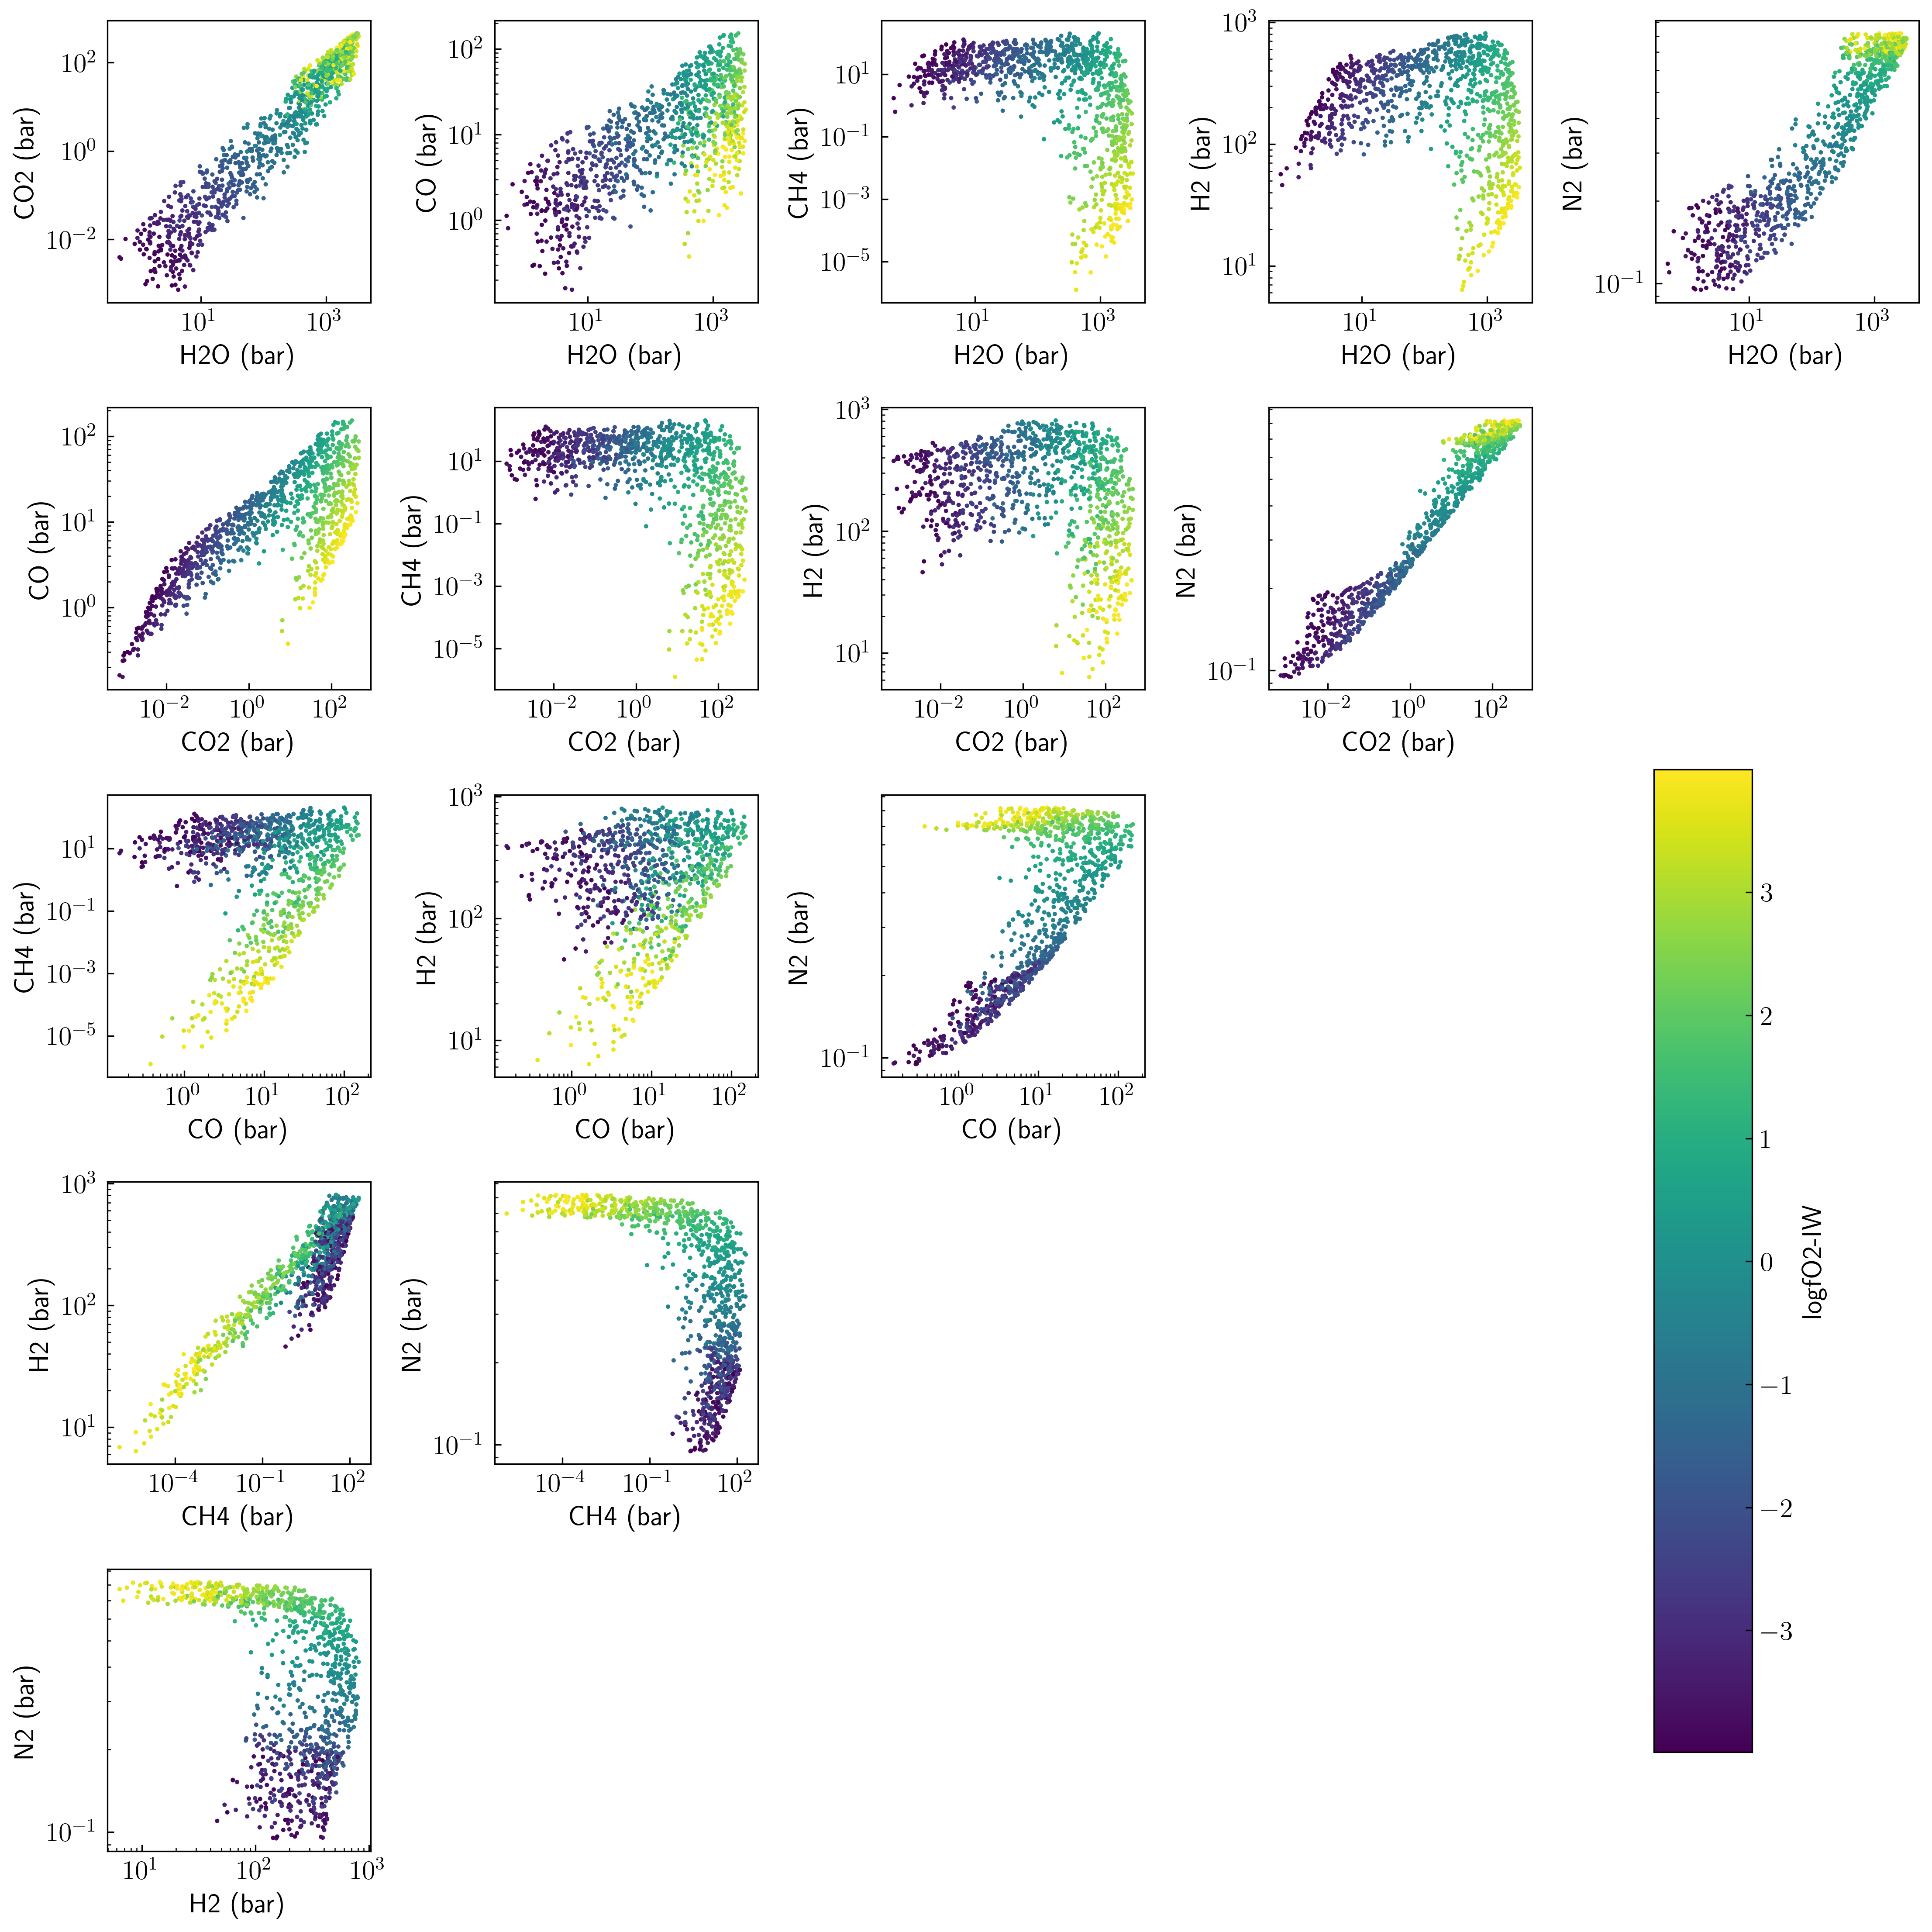

In [103]:

fig, ax = plt.subplots(figsize=(15, 15), ncols=5, nrows=5)

#colormap = plt.cm.get_cmap('RdYlGn') # 'plasma' or 'viridis'
colors=df_T1e.fO2_shift
#H2O-CO2
ax[0,0].scatter(df_T1e.H2O_pp, df_T1e.CO2_pp, c=colors, s=2)
ax[0,0].set_xscale('log')
ax[0,0].set_yscale('log')
ax[0,0].set_xlabel('H2O (bar)')
ax[0,0].set_ylabel('CO2 (bar)')

#H2O-CO
ax[0,1].scatter(df_T1e.H2O_pp, df_T1e.CO_pp, c=colors, s=2)
ax[0,1].set_xscale('log')
ax[0,1].set_yscale('log')
ax[0,1].set_xlabel('H2O (bar)')
ax[0,1].set_ylabel('CO (bar)')

#H2O-CH4
ax[0,2].scatter(df_T1e.H2O_pp, df_T1e.CH4_pp, c=colors, s=2)
ax[0,2].set_xscale('log')
ax[0,2].set_yscale('log')
ax[0,2].set_xlabel('H2O (bar)')
ax[0,2].set_ylabel('CH4 (bar)')

#H2O-H2
ax[0,3].scatter(df_T1e.H2O_pp, df_T1e.H2_pp, c=colors, s=2)
ax[0,3].set_xscale('log')
ax[0,3].set_yscale('log')
ax[0,3].set_xlabel('H2O (bar)')
ax[0,3].set_ylabel('H2 (bar)')

#H2O-N2
ax[0,4].scatter(df_T1e.H2O_pp, df_T1e.N2_pp, c=colors, s=2)
ax[0,4].set_xscale('log')
ax[0,4].set_yscale('log')
ax[0,4].set_xlabel('H2O (bar)')
ax[0,4].set_ylabel('N2 (bar)')

#CO2-CO
ax[1,0].scatter(df_T1e.CO2_pp, df_T1e.CO_pp, c=colors, s=2)
ax[1,0].set_xscale('log')
ax[1,0].set_yscale('log')
ax[1,0].set_xlabel('CO2 (bar)')
ax[1,0].set_ylabel('CO (bar)')

#CO2-CH4
ax[1,1].scatter(df_T1e.CO2_pp, df_T1e.CH4_pp, c=colors, s=2)
ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')
ax[1,1].set_xlabel('CO2 (bar)')
ax[1,1].set_ylabel('CH4 (bar)')

#CO2-H2
ax[1,2].scatter(df_T1e.CO2_pp, df_T1e.H2_pp, c=colors, s=2)
ax[1,2].set_xscale('log')
ax[1,2].set_yscale('log')
ax[1,2].set_xlabel('CO2 (bar)')
ax[1,2].set_ylabel('H2 (bar)')

#CO2-N2
ax[1,3].scatter(df_T1e.CO2_pp, df_T1e.N2_pp, c=colors, s=2)
ax[1,3].set_xscale('log')
ax[1,3].set_yscale('log')
ax[1,3].set_xlabel('CO2 (bar)')
ax[1,3].set_ylabel('N2 (bar)')

#CO-CH4
ax[2,0].scatter(df_T1e.CO_pp, df_T1e.CH4_pp, c=colors, s=2)
ax[2,0].set_xscale('log')
ax[2,0].set_yscale('log')
ax[2,0].set_xlabel('CO (bar)')
ax[2,0].set_ylabel('CH4 (bar)')

#CO-H2
ax[2,1].scatter(df_T1e.CO_pp, df_T1e.H2_pp, c=colors, s=2)
ax[2,1].set_xscale('log')
ax[2,1].set_yscale('log')
ax[2,1].set_xlabel('CO (bar)')
ax[2,1].set_ylabel('H2 (bar)')

#CO-N2
ax[2,2].scatter(df_T1e.CO_pp, df_T1e.N2_pp, c=colors, s=2)
ax[2,2].set_xscale('log')
ax[2,2].set_yscale('log')
ax[2,2].set_xlabel('CO (bar)')
ax[2,2].set_ylabel('N2 (bar)')

#CH4-H2
ax[3,0].scatter(df_T1e.CH4_pp, df_T1e.H2_pp, c=colors, s=2)
ax[3,0].set_xscale('log')
ax[3,0].set_yscale('log')
ax[3,0].set_xlabel('CH4 (bar)')
ax[3,0].set_ylabel('H2 (bar)')

#CH4-N2
ax[3,1].scatter(df_T1e.CH4_pp, df_T1e.N2_pp, c=colors, s=2)
ax[3,1].set_xscale('log')
ax[3,1].set_yscale('log')
ax[3,1].set_xlabel('CH4 (bar)')
ax[3,1].set_ylabel('N2 (bar)')

#H2-N2
sc = ax[4,0].scatter(df_T1e.H2_pp, df_T1e.N2_pp, c=colors, s=2)
ax[4,0].set_xscale('log')
ax[4,0].set_yscale('log')
ax[4,0].set_xlabel('H2 (bar)')
ax[4,0].set_ylabel('N2 (bar)')

ax[1, 4].axis('off')
ax[2, 3].axis('off')
ax[2, 4].axis('off')
ax[3, 2].axis('off')
ax[3, 3].axis('off')
ax[3, 4].axis('off')
ax[4, 1].axis('off')
ax[4, 2].axis('off')
ax[4, 3].axis('off')
ax[4, 4].axis('off')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.10, 0.05, 0.5])
fig.colorbar(sc, cax=cbar_ax, label='logfO2-IW')

fig.tight_layout()
plt.savefig("Plots/T1e_HCON_1500K_MF1_1000its.jpg", dpi=1000)
plt.show()

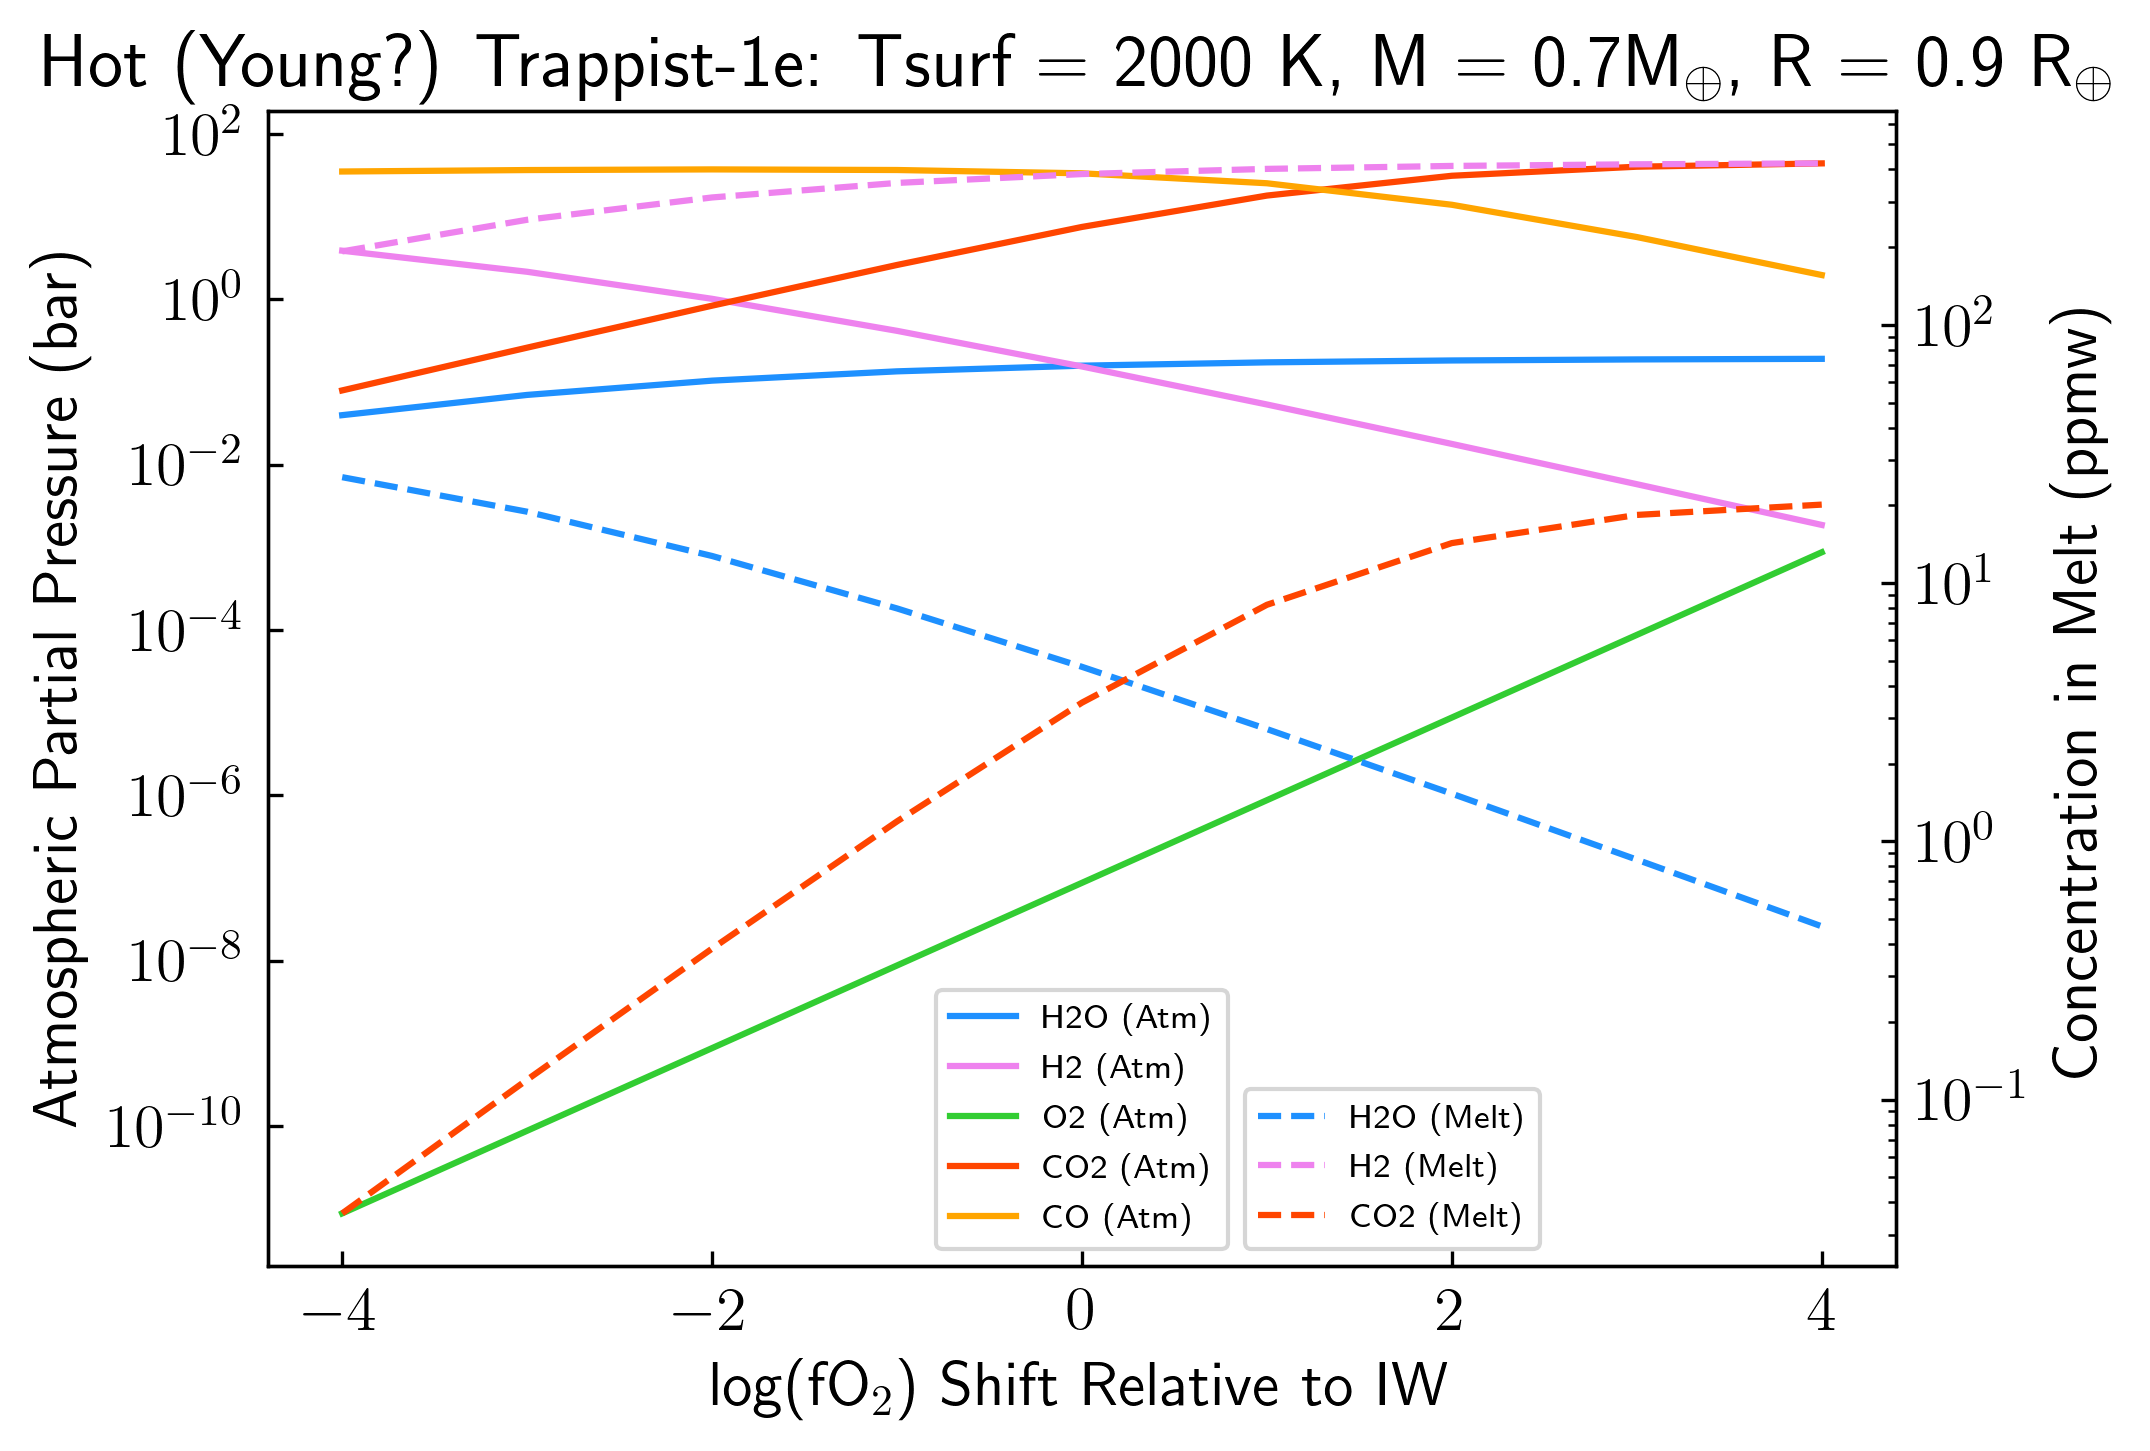

In [11]:
fig, ax = plt.subplots()
ax.plot(df_fO2.fO2_shift, df_fO2.H2O_pp, color='dodgerblue', label='H2O (Atm)')
ax.plot(df_fO2.fO2_shift, df_fO2.H2_pp, color='violet', label='H2 (Atm)')
ax.plot(df_fO2.fO2_shift, df_fO2.O2_pp, color='limegreen', label='O2 (Atm)')
ax.plot(df_fO2.fO2_shift, df_fO2.CO2_pp, color='orangered', label='CO2 (Atm)')
ax.plot(df_fO2.fO2_shift, df_fO2.CO_pp, color='orange', label='CO (Atm)')

ax2 = ax.twinx()
ax2.plot(df_fO2.fO2_shift, df_fO2.H2O_melt, color='dodgerblue', linestyle='--', label='H2O (Melt)')
ax2.plot(df_fO2.fO2_shift, df_fO2.H2_melt, color='violet', linestyle='--', label='H2 (Melt)')
#ax2.plot(df_fO2.fO2_shift, df_fO2.O2_melt, color='limegreen', linestyle='--', label='O2 (Melt)')
ax2.plot(df_fO2.fO2_shift, df_fO2.CO2_melt, color='orangered', linestyle='--', label='CO2 (Melt)')
#ax2.plot(df_fO2.fO2_shift, df_fO2.CO_melt, color='orange', linestyle='--', label='CO (Melt)')

ax.set_xlabel(r'log(fO$_2$) Shift Relative to IW')
ax.set_ylabel('Atmospheric Partial Pressure (bar)')
ax2.set_ylabel('Concentration in Melt (ppmw)')
ax.set_yscale('log')
ax2.set_yscale('log')
ax.legend(fontsize=8, loc=8)
ax2.legend(fontsize=8, loc=(0.6, 0.015))
plt.title(r'Hot (Young?) Trappist-1e: Tsurf = 2000 K, M = 0.7M$_\oplus$, R = 0.9 R$_\oplus$')
#plt.savefig('data/Plots/PlanetTrial1_HotTrappist1e_CHO_2000K.jpg', dpi=1000)
plt.show()

## Simulating K2-18 b

In [14]:
planet: Planet = Planet(surface_temperature=1500, mantle_mass = 3.6315E25, surface_radius = 1.6647E7)
#planet: Planet = Planet()


In [15]:
species: Species = Species(
        [
            GasSpecies(
                chemical_formula="H2",
                solubility=BasaltH2(),
                thermodynamic_class=thermodynamic_data,
               # eos=IdealGas(),
            ),
            GasSpecies(
                chemical_formula="H2O",
                solubility=BasaltDixonH2O(),
                thermodynamic_class=thermodynamic_data,
               # eos=eos_models_HP["H2O"],
            ),
            GasSpecies(
                chemical_formula="O2",
                solubility=NoSolubility(),
                thermodynamic_class=thermodynamic_data,
                #eos=eos_models_HP["O2"]
            ),
            GasSpecies(
                chemical_formula="CO",
                solubility=BasaltCO(),
                thermodynamic_class=thermodynamic_data,
                #eos=eos_models_HP["CO"],
            ),
            GasSpecies(
                chemical_formula="CO2",
                solubility=BasaltDixonCO2(),
                thermodynamic_class=thermodynamic_data,
                #eos=eos_models_HP["CO2"],
            ),
            GasSpecies(
                chemical_formula="CH4",
                solubility=NoSolubility(),
                thermodynamic_class=thermodynamic_data,
                #eos=eos_models_HP["CH4"],
            ),
        ]
    )

[13:37:11 - atmodeller.interfaces          - WARNING  ] - Combining different thermodynamic data may result in inconsistencies
[13:37:11 - atmodeller.interfaces          - WARNING  ] - Combining different thermodynamic data may result in inconsistencies
[13:37:11 - atmodeller.interfaces          - WARNING  ] - Combining different thermodynamic data may result in inconsistencies
[13:37:11 - atmodeller.interfaces          - WARNING  ] - Combining different thermodynamic data may result in inconsistencies
[13:37:11 - atmodeller.interfaces          - WARNING  ] - Combining different thermodynamic data may result in inconsistencies
[13:37:11 - atmodeller.interfaces          - WARNING  ] - Combining different thermodynamic data may result in inconsistencies


In [70]:
oceans: float = 10
h_kg: float = earth_oceans_to_kg(oceans)
c_kg: float = h_kg

constraints: SystemConstraints = SystemConstraints(
    [
        FugacityConstraint(species="H2", value=958),
        IronWustiteBufferConstraintHirschmann(),
        MassConstraint(species="C", value=c_kg),
    ]
)

system: InteriorAtmosphereSystem = InteriorAtmosphereSystem(species=species, planet=planet)

In [71]:
initial_solution: np.ndarray = np.array([1000, 1000, 1e-8, 100, 10, 1])
system.solve(constraints, initial_solution=initial_solution)

In [72]:
system.output

{'temperature': 2000,
 'total_pressure_in_atmosphere': 2026.6981086063047,
 'mean_molar_mass_in_atmosphere': 0.010667466253504542,
 'H2': GasSpeciesOutput(mass_in_atmosphere=5.079421345277659e+21, mass_in_solid=0.0, mass_in_melt=1.6732962580062393e+22, moles_in_atmosphere=2.5197017212702226e+24, moles_in_melt=8.30056649152202e+24, moles_in_solid=0.0, ppmw_in_solid=0.0, ppmw_in_melt=460.7727545108741, fugacity=957.9999999999998, fugacity_coefficient=0.9999999999999997, pressure_in_atmosphere=958.0000000000001, volume_mixing_ratio=0.47269003505351176, mass_in_total=2.1812383925340054e+22),
 'H2O': GasSpeciesOutput(mass_in_atmosphere=4.900071852467356e+22, mass_in_solid=0.0, mass_in_melt=1.1269436003070279e+24, moles_in_atmosphere=2.7199521453459807e+24, moles_in_melt=6.255485134969139e+25, moles_in_solid=0.0, ppmw_in_solid=0.0, ppmw_in_melt=31032.454916894614, fugacity=1034.1359587308082, fugacity_coefficient=0.9999999999999997, pressure_in_atmosphere=1034.1359587308086, volume_mixing_ra

In [16]:
interior_atmosphere: InteriorAtmosphereSystem = InteriorAtmosphereSystem(species=species, planet=planet)

In [18]:
#Vary amount of H (expressed as Earth oceans)

number_of_realisations: int = 191

number_Earth_oceans_arr: np.ndarray = np.arange(1,16)

#print(number_Earth_oceans_arr)

#Vary abount of H in atmosphere:
H2_fugacity_arr: np.ndarray = np.arange(1000, 20100, 100)
print((float(H2_fugacity_arr[0])))

1000.0


In [71]:
#intial solution array:

CO2_fugacity_arr: np.ndarray = 5*np.ones(191)


191


In [19]:
out: list[dict[str, float]] = []

for realisation in range(number_of_realisations):

    mass_C: float = earth_oceans_to_kg(10)
    H2_fug = H2_fugacity_arr[realisation]
    constraints: SystemConstraints = SystemConstraints([
        FugacityConstraint(species="H2", value=H2_fug),
        FugacityConstraint(species="CO2", value=5),
        IronWustiteBufferConstraintHirschmann()
    ])
    
    initial_solution: np.ndarray = np.array([H2_fug, 10000, 1e-12, 5, 5, 400])
    # Recall that changing attributes on the planet 'object' will be 'seen' by interior_atmosphere.
    interior_atmosphere.solve(constraints, factor=1, tol = 1e-6, initial_solution=initial_solution)
    #out_realisation: dict[str,float] = interior_atmosphere.solution_dict
    
    H2_output = interior_atmosphere.output['H2'].pressure_in_atmosphere
    H2O_output = interior_atmosphere.output['H2O'].pressure_in_atmosphere
    O2_output = interior_atmosphere.output['O2'].pressure_in_atmosphere 

    H2_melt = interior_atmosphere.output['H2'].ppmw_in_melt
    H2O_melt = interior_atmosphere.output['H2O'].ppmw_in_melt
    O2_melt = interior_atmosphere.output['O2'].ppmw_in_melt
    CO2_melt = interior_atmosphere.output['CO2'].ppmw_in_melt
    CO_melt = interior_atmosphere.output['CO'].ppmw_in_melt

    out_realisation: dict[str,float] = interior_atmosphere.solution_dict

    # Include the parameters in the output.

    out_realisation['H2_melt'] = H2_melt
    out_realisation['H2O_melt'] = H2O_melt
    out_realisation['O2_melt'] = O2_melt
    out_realisation['CO2_melt'] = CO2_melt
    out_realisation['CO_melt'] = CO_melt

    out_realisation['H2_fugacity'] = H2_fugacity_arr[realisation]

    out.append(out_realisation)

    filename: str = "data/science_cases_files/atmodeller_K218b_varyH2Pto2GPa_IdealGas_1500K.csv"
    print("Writing output to: %s", filename)
    fieldnames: list[str] = list(out[0].keys())
    with open(filename, "w", newline="", encoding="utf-8") as csvfile:
        writer: csv.DictWriter = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(out)

Writing output to: %s data/science_cases_files/atmodeller_K218b_varyH2Pto2GPa_IdealGas_1500K.csv
Writing output to: %s data/science_cases_files/atmodeller_K218b_varyH2Pto2GPa_IdealGas_1500K.csv
Writing output to: %s data/science_cases_files/atmodeller_K218b_varyH2Pto2GPa_IdealGas_1500K.csv
Writing output to: %s data/science_cases_files/atmodeller_K218b_varyH2Pto2GPa_IdealGas_1500K.csv
Writing output to: %s data/science_cases_files/atmodeller_K218b_varyH2Pto2GPa_IdealGas_1500K.csv
Writing output to: %s data/science_cases_files/atmodeller_K218b_varyH2Pto2GPa_IdealGas_1500K.csv
Writing output to: %s data/science_cases_files/atmodeller_K218b_varyH2Pto2GPa_IdealGas_1500K.csv
Writing output to: %s data/science_cases_files/atmodeller_K218b_varyH2Pto2GPa_IdealGas_1500K.csv
Writing output to: %s data/science_cases_files/atmodeller_K218b_varyH2Pto2GPa_IdealGas_1500K.csv
Writing output to: %s data/science_cases_files/atmodeller_K218b_varyH2Pto2GPa_IdealGas_1500K.csv
Writing output to: %s data/sci

SystemExit: 

/Users/maggiethompson/Programs/atmodeller/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [36]:
import pandas as pd
datafile_K218b_try: str = f"data/science_cases_files/atmodeller_K218b_varyH2Pto2GPa_RealGas_1500K.csv"
df_K218b_try: pd.DataFrame = pd.read_csv(datafile_K218b_try, skiprows=1, names=('H2','H2O','O2','CO','CO2','CH4','H2_melt','H2O_melt','O2_melt','CO2_melt','CO_melt','H2_fugacity'))

print(df_K218b_try)

               H2          H2O            O2         CO       CO2        CH4  \
0      727.090289   871.998239  2.875121e-12   8.958093  3.168227  42.060462   
1      777.359621   960.098892  2.910307e-12   8.557061  3.050008  48.282206   
2      824.746990  1047.884999  2.945157e-12   8.184113  2.939044  54.586422   
3      869.491261  1135.167414  2.979655e-12   7.836838  2.834786  60.940691   
4      911.792552  1221.912316  3.013810e-12   7.512805  2.736651  67.316499   
..            ...          ...           ...        ...       ...        ...   
186  45701.545874  1777.284296  1.376980e-10   0.000466  0.000252   0.032963   
187  45672.305072  1787.992747  1.374827e-10   0.000468  0.000253   0.033450   
188  45643.123591  1798.713155  1.372686e-10   0.000469  0.000253   0.033941   
189  45614.000747  1809.445494  1.370557e-10   0.000470  0.000254   0.034437   
190  20000.000000    10.000000  1.370557e-10  10.000000  5.000000  10.000000   

         H2_melt       H2O_melt  O2_mel

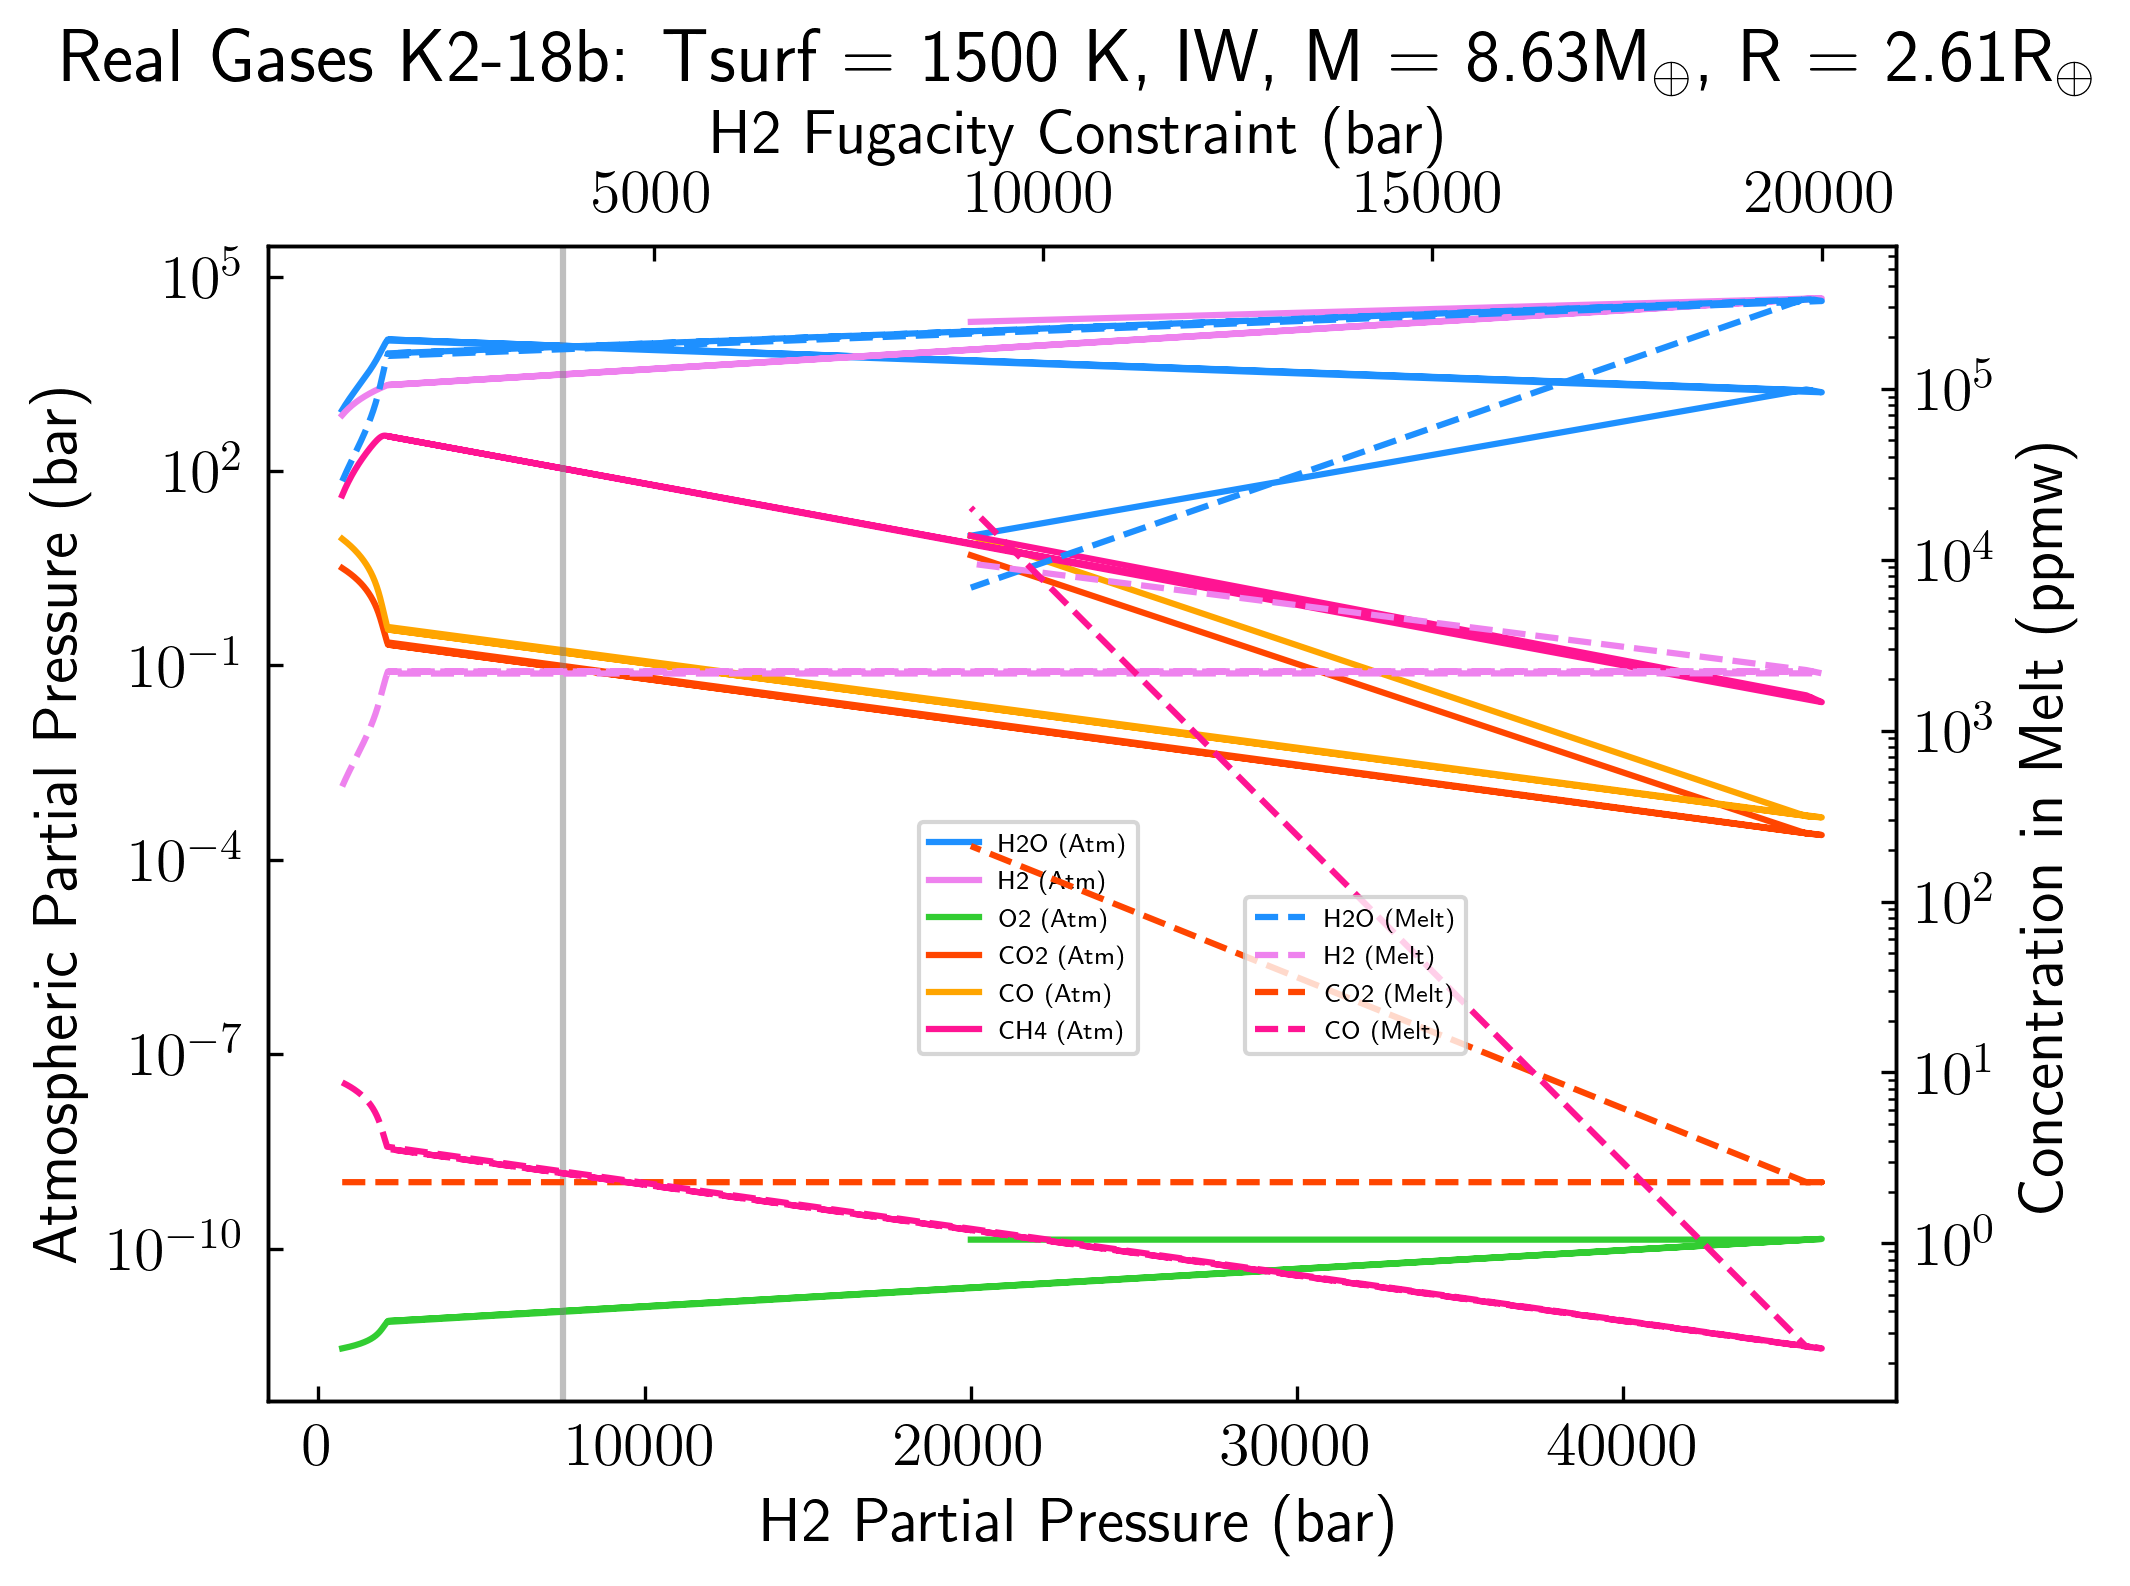

In [37]:
fig, ax = plt.subplots()
ax.plot(df_K218b_try.H2, df_K218b_try.H2O, color='dodgerblue', label='H2O (Atm)')
ax.plot(df_K218b_try.H2, df_K218b_try.H2, color='violet', label='H2 (Atm)')
ax.plot(df_K218b_try.H2, df_K218b_try.O2, color='limegreen', label='O2 (Atm)')
ax.plot(df_K218b_try.H2, df_K218b_try.CO2, color='orangered', label='CO2 (Atm)')
ax.plot(df_K218b_try.H2, df_K218b_try.CO, color='orange', label='CO (Atm)')
ax.plot(df_K218b_try.H2, df_K218b_try.CH4, color='deeppink', label='CH4 (Atm)')


ax2 = ax.twinx()
ax2.plot(df_K218b_try.H2, df_K218b_try.H2O_melt, color='dodgerblue', linestyle='--', label='H2O (Melt)')
ax2.plot(df_K218b_try.H2, df_K218b_try.H2_melt, color='violet', linestyle='--', label='H2 (Melt)')
#ax2.plot(df_fO2.fO2_shift, df_fO2.O2_melt, color='limegreen', linestyle='--', label='O2 (Melt)')
ax2.plot(df_K218b_try.H2, df_K218b_try.CO2_melt, color='orangered', linestyle='--', label='CO2 (Melt)')
ax2.plot(df_K218b_try.H2, df_K218b_try.CO_melt, color='deeppink', linestyle='--', label='CO (Melt)')
ax.axvline(x=7500, color='gray', alpha=0.5)
ax3 = ax.twiny()
ax3.plot(df_K218b_try.H2_fugacity, df_K218b_try.H2, alpha=0)
ax3.set_xlabel(r'H2 Fugacity Constraint (bar)')
ax.set_xlabel(r'H2 Partial Pressure (bar)')
ax.set_ylabel('Atmospheric Partial Pressure (bar)')
ax2.set_ylabel('Concentration in Melt (ppmw)')
ax.set_yscale('log')
ax2.set_yscale('log')

ax.legend(fontsize=6, loc=(0.4, 0.3))
ax2.legend(fontsize=6, loc=(0.6, 0.3))
plt.title(r'Real Gases K2-18b: Tsurf = 1500 K, IW, M = 8.63M$_\oplus$, R = 2.61R$_\oplus$')
#plt.savefig('data/Plots/K218b_CHOSpecies_1500K_IW_IdealGas_Pupto2GPa.jpg', dpi=1000, bbox_inches='tight')
plt.show()

In [28]:
print(df_K218b_try.CO)

0      7.273294
1      6.337788
2      5.565684
3      4.924222
4      4.387432
         ...   
186    0.114634
187    0.253518
188    0.094859
189    0.137936
190    0.284494
Name: CO, Length: 191, dtype: float64


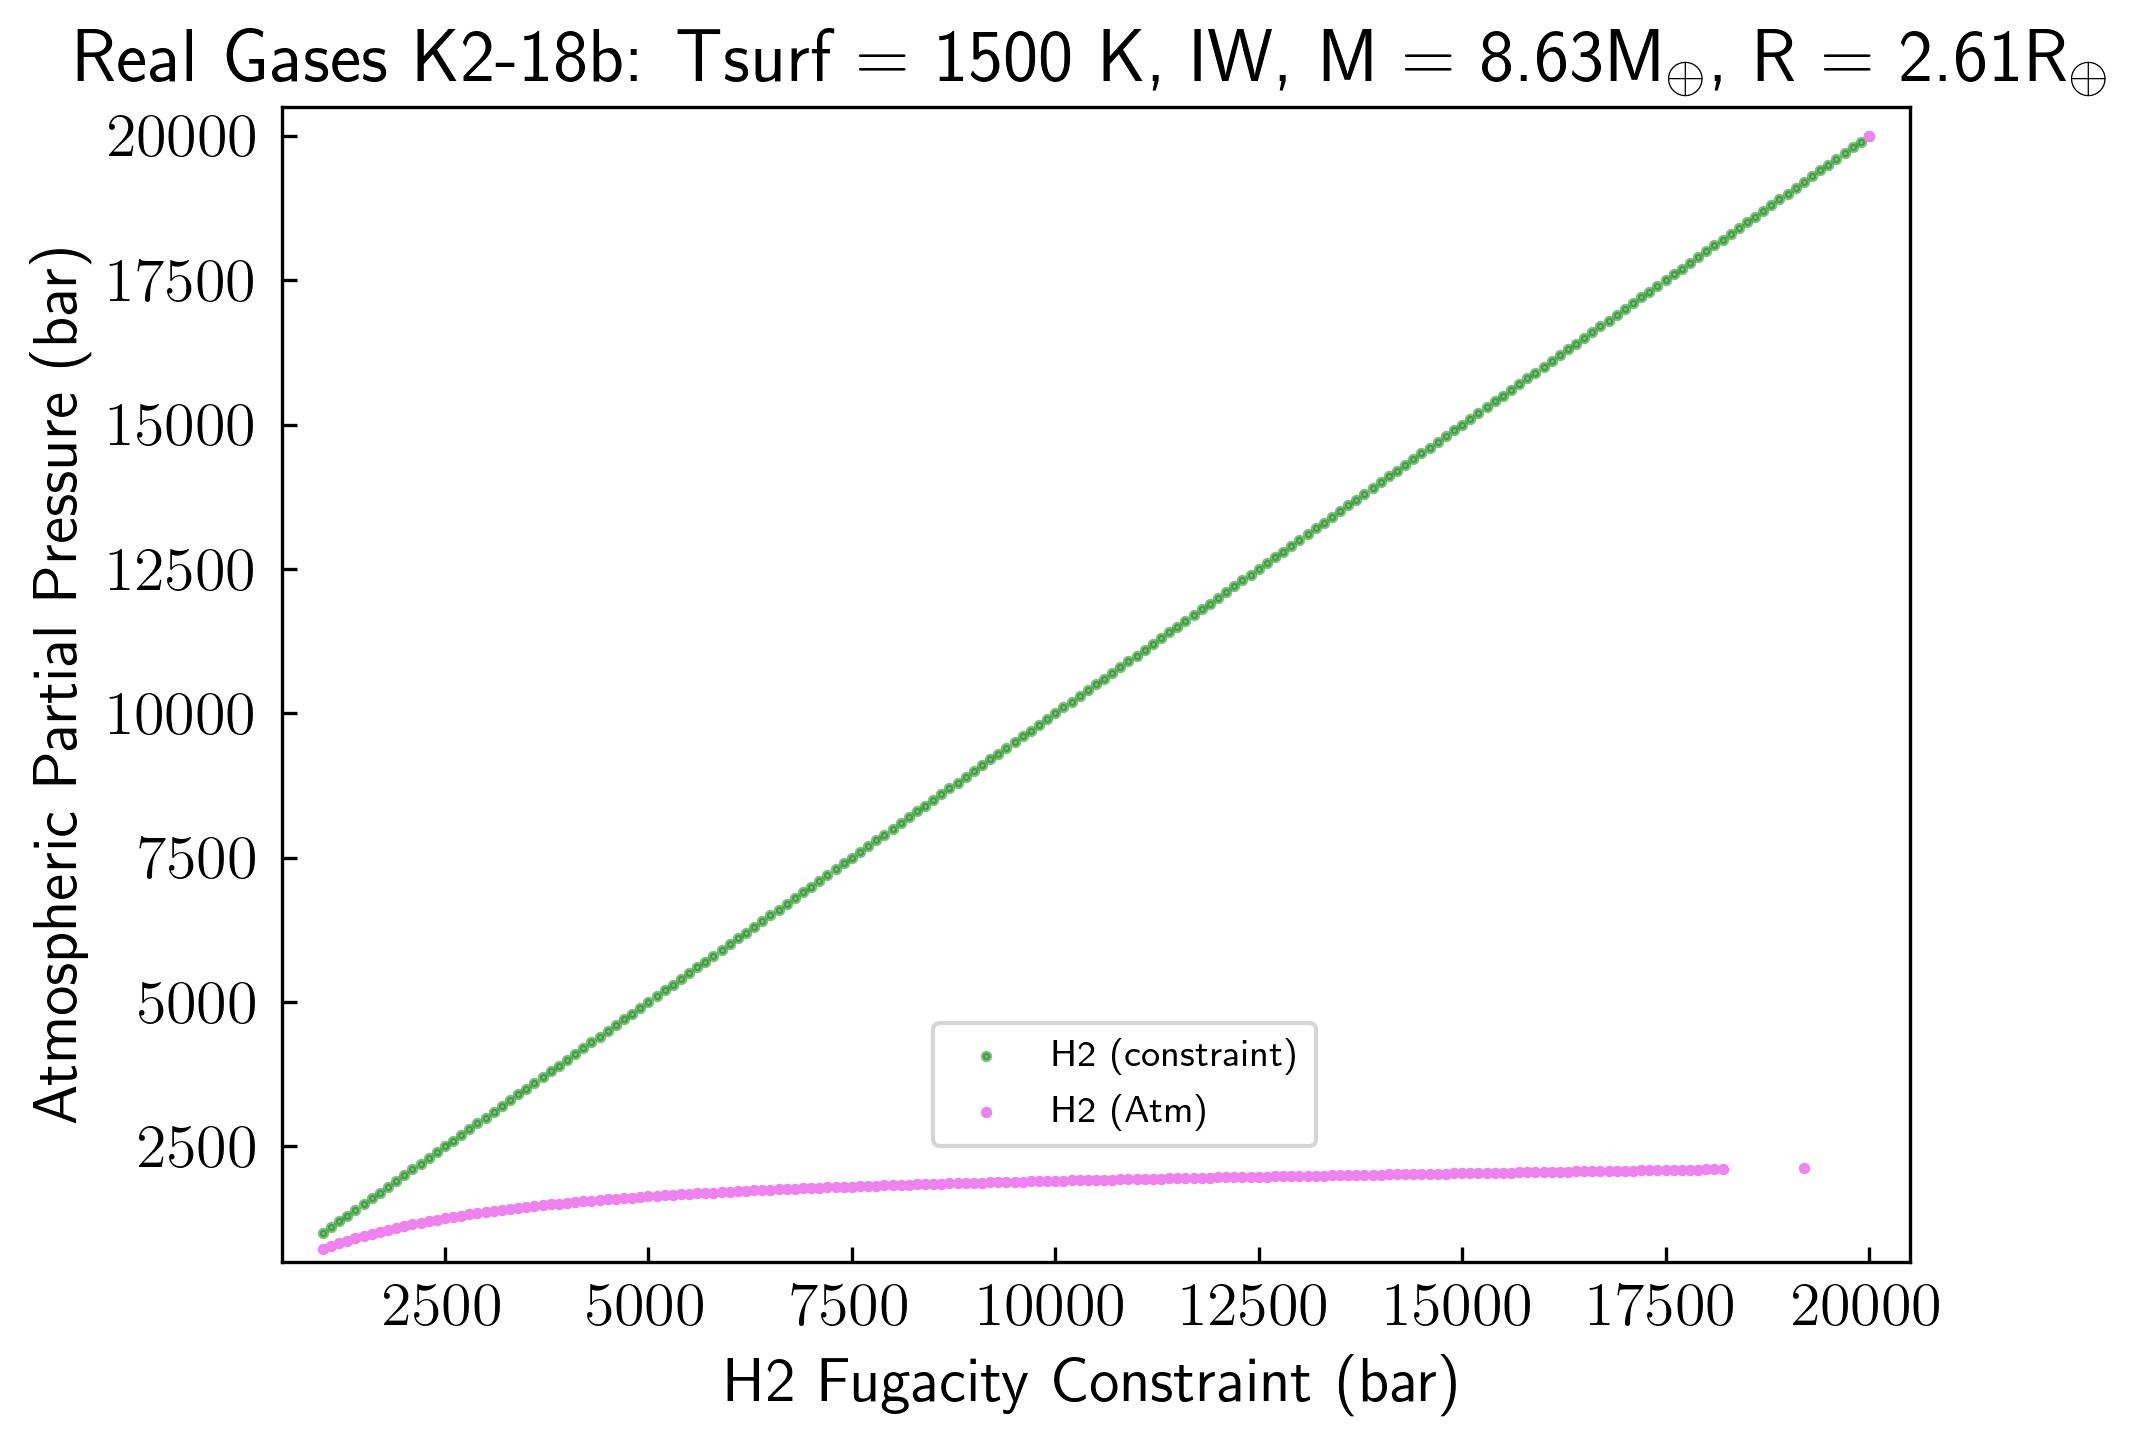

In [38]:
fig, ax = plt.subplots()
#ax.scatter(df_K218b_try.H2_fugacity, df_K218b_try.H2O, s=3, color='dodgerblue', label='H2O (Atm)')
ax.scatter(df_K218b_try.H2_fugacity, df_K218b_try.H2_fugacity, s=3, color='green', alpha=0.5, label='H2 (constraint)')
ax.scatter(df_K218b_try.H2_fugacity, df_K218b_try.H2, s=3, color='violet', label='H2 (Atm)')

#ax2 = ax.twinx()
#ax2.plot(df_K218b_try.H2_fugacity, df_K218b_try.H2O_melt, color='dodgerblue', linestyle='--', label='H2O (Melt)')
#ax2.plot(df_K218b_try.H2_fugacity, df_K218b_try.H2_melt, color='violet', linestyle='--', label='H2 (Melt)')
ax.set_xlim(500,20500)
ax.set_ylim(500,20500)

#ax3 = ax.twiny()
#ax3.plot(df_K218b_try.H2_fugacity, df_K218b_try.H2)
#ax3.set_xlabel(r'H2 Fugacity Constraint (bar)')
ax.set_xlabel(r'H2 Fugacity Constraint (bar)')
ax.set_ylabel('Atmospheric Partial Pressure (bar)')
#ax2.set_ylabel('Concentration in Melt (ppmw)')
#ax.set_yscale('log')
#ax2.set_yscale('log')

ax.legend(fontsize=9, loc=(0.4, 0.1))
ax2.legend(fontsize=6, loc=(0.6, 0.1))
plt.title(r'Real Gases K2-18b: Tsurf = 1500 K, IW, M = 8.63M$_\oplus$, R = 2.61R$_\oplus$')
#plt.savefig('data/Plots/K218b_CHOSpecies_1500K_IW_IdealGas_Pupto2GPa_H2Check_onlyFugacityConstraints.jpg', dpi=1000, bbox_inches='tight')
plt.show()